![DSME-logo](./img/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

# Comparing the abilities of TD(0) and constant-&alpha; MC

## Library Imports

In [9]:
import gymnasium as gym
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import custom_envs
import copy
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Initializations

In this example, we compare the prediction abilities of TD(0) and constant-&alpha; MC for learning state value functions. Unlike our previous examples with Frozenlake, we'll use a simple Random Walk environment, which is a classic testbed for comparing temporal difference learning methods with Monte Carlo methods.

The Random Walk environment consists of 7 states (numbered 0 to 6), with states 0 and 6 being terminal states. The agent starts in the middle state (state 3) and can move left or right. The agent receives a reward of 1 when it reaches the rightmost terminal state (state 6) and 0 otherwise.

<img src="./img/random_walk.png" alt="Random Walk Environment" width="600" height="150" />

Our goal is to compare how quickly and smooth TD(0) and constant-&alpha; MC methods learn the true state value function for a given policy. We'll measure the mean squared error between the estimated and true value functions over training episodes.


### Obtaining Policy and State Value Function

To compare the two methods, we first need a policy, as well as the associated value function. Here, we use policy iteration to determine both. Dynamic Programming is particularly suitable for determining the state value function that we use for reference, since it can determine it stably with adjustable accuracy, specified in `update_threshold`. The details of the implementation of the agent that performs the policy iteration are assumed to be given here. For more details on Dynamic Programming, we refer to previous lectures.


In [10]:
from gymnasium import spaces


class MarkovDecisionProcess():
    def __init__(self, num_states, dynamics_fn):
        self.num_states = num_states
        self.actions_per_state = [] # list containing the actions available per state
        for state in dynamics_fn:
            actions = list(dynamics_fn[state].keys())
            self.actions_per_state.append(actions)
        self.P = dynamics_fn # P[s][a] represents a list of possible transitions and rewards given state s and a

class RandomWalkEnv(gym.Env, MarkovDecisionProcess):
    def __init__(self, p=0.9):
        # Gym spaces
        self.observation_space = spaces.Discrete(7)  # states 0-6
        self.action_space = spaces.Discrete(2)      # actions 0 (left) and 1 (right)

        # Initialize state
        self.state = 3  # start state
        self.start_state = 3
        self.terminal_states = {0, 6}

        # Define transition dynamics for MarkovDecisionProcess
        dynamics_fn = {}
        for s in range(1, 6):
            left_reward = 0 if s == 1 else 0
            right_reward = 1 if s == 5 else 0

            dynamics_fn[s] = {
                0: [  # left action
                    (1-p, s - 1, left_reward),
                    (p/2, s - 1, left_reward),
                    (p/2, s + 1, right_reward)
                ],
                1: [  # right action
                    (1-p, s + 1, right_reward),
                    (p/2, s - 1, left_reward),
                    (p/2, s + 1, right_reward)
                ]
            }

        # Terminal states
        dynamics_fn[0] = {0: [(1.0, 0, 0)], 1: [(1.0, 0, 0)]}
        dynamics_fn[6] = {0: [(1.0, 6, 0)], 1: [(1.0, 6, 0)]}

        # Initialize MarkovDecisionProcess parent
        MarkovDecisionProcess.__init__(self, num_states=7, dynamics_fn=dynamics_fn)

        self.p = p

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = self.start_state
        return self.state, {}

    def step(self, action):
        assert self.action_space.contains(action)

        # Get possible transitions for current state-action pair
        transitions = self.P[self.state][action]

        # Sample transition based on probabilities
        probs = [t[0] for t in transitions]
        next_states = [t[1] for t in transitions]
        rewards = [t[2] for t in transitions]

        idx = self.np_random.choice(len(transitions), p=probs)

        self.state = next_states[idx]
        reward = rewards[idx]
        terminated = self.state in self.terminal_states

        return self.state, reward, terminated, False, {}

    def render(self):
        pass  # Optional: implement if visualization is needed

class DP_Agent():
    def __init__(self, mdp, gamma=0.9, update_threshold=0.05):
        self.mdp = mdp # contains state transition function, num_states and actions
        self.update_threshold = update_threshold # stopping distance as criteria for stopping policy evaluation
        self.state_value_fn = np.zeros(self.mdp.num_states) # a table leading from state to value expectations
        self.policy = [[1 for _ in actions] for actions in self.mdp.actions_per_state]
        self.policy = [[action / len(actions) for action in actions] for actions in self.policy]
        self.gamma = gamma # discount rate for return

    def get_action(self, state):
        # Choose action based on the probabilities defined within the policy
        action = np.random.choice(np.flatnonzero(np.isclose(self.policy[state], max(self.policy[state]))))
        return action

    def get_action_value(self, state, action):
        # Calculate action value for state action pair based on the transition probabilities of the mdp
        action_value = 0
        for transition in self.mdp.P[state][action]:
            transition_prob = transition[0]  # prob of next state
            state_value_obs = transition[1]  # id of next state
            reward = transition[2]  # reward of next state
            action_value += transition_prob * (reward + self.gamma * self.state_value_fn[state_value_obs])
        return action_value

    def train(self):
        policy_stable = False
        while not policy_stable:
            # Use policy evaluation to update the value function
            self.policy_evaluation()
            # Use new value function to update the policy
            policy_stable = self.improve_policy() # if the policy stops changing, this ends the training process

    def policy_evaluation(self):
        # Policy evaluation for all states
        max_update = self.update_threshold + 1
        while max_update > self.update_threshold:
            max_update = 0
            for state in range(self.mdp.num_states):
                old_state_value = self.state_value_fn[state]
                new_state_value = 0
                actions = np.nonzero(self.policy[state])[0]
                for action in actions:
                    action_prob = self.policy[state][action]
                    new_state_value += action_prob * self.get_action_value(state, action)
                self.state_value_fn[state] = max(new_state_value, old_state_value)
                max_update = max(max_update, np.abs(old_state_value - self.state_value_fn[state]))

    def improve_policy(self):
        # Initiates improving the policy
        policy_stable = True
        # Cache current policy
        current_policy = self.policy
        # Create empty policy to store the best possible actions based on current value function
        best_policy = [[0 for _ in actions] for actions in self.mdp.actions_per_state]
        for state in range(self.mdp.num_states):
            # Calculate best possible policy based on current value function
            action_values = []
            for action in range(len(self.mdp.actions_per_state[state])):
                action_values.append(self.get_action_value(state, action))  # calculate q(s,a)
            action_value_max = max(action_values)
            best_actions = np.where(np.isclose(action_values, np.max(action_values), rtol=1e-9, atol=1e-9))[0]
            # find indices where maximum value occurs
            for index in best_actions:
                best_policy[state][index] = 1
            best_policy[state] = [best_policy[state][action] / len(best_actions)
                                  for action in self.mdp.actions_per_state[state]]
            # If the current policy is not the best policy, update it
            if not np.array_equal(current_policy[state], best_policy[state]):
                policy_stable = False
                self.policy[state] = best_policy[state]
        return policy_stable

    def visualize(self):
        print('State value function of the agent:')
        states = range(self.mdp.num_states)  # 7 states from 0 to 6

        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        plt.plot(states, self.state_value_fn, 'bo-')  # Plot state values as blue dots connected by lines

        # Add value labels above each point
        for state, value in enumerate(self.state_value_fn):
            ax.text(state, value + 0.02, f'{value:.3f}',
                    ha='center', va='bottom', fontsize=10)

        # Customize the plot
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xlabel('State')
        plt.ylabel('Value')
        plt.title('State Value Function')
        plt.xticks(states)
        plt.ylim(min(self.state_value_fn) - 0.1, max(self.state_value_fn) + 0.1)

        plt.show()


    def render_policy(self):
        print('Policy of the agent:')
        print('-----------------------------')
        out = ''
        for i in range(self.mdp.num_states):
            if i == 0 or i == 6:  # terminal states
                out += '■ '  # square for terminal state
            else:
                # Get the action probabilities for this state
                action_probs = self.policy[i]
                if action_probs[0] > action_probs[1]:
                    out += '← '  # left arrow if left action is preferred
                elif action_probs[1] > action_probs[0]:
                    out += '→ '  # right arrow if right action is preferred
                else:
                    out += '↔ '  # both arrows if equal probability
        print(out)


We now create the map, the environment and the agent, let the agent train until the optimal policy and the corresponding value function is found and then extract the state value function and policy. Under `target_state_value_fn` the state value function determined via DP now serves as a reference for TD(0) and constant-&alpha; MC.

In [11]:
# Set up map, environment, and agent
gamma = 1.0
mdp = RandomWalkEnv(p=1) # in our case contains dynamics function
agent = DP_Agent(mdp, update_threshold=1e-9, gamma=gamma)

# Train the agent.
agent.train()

# Extract the necessary functions for comparison
policy = agent.policy
target_state_value_fn = agent.state_value_fn

Below, we show both the state value function, and the resulting policy. The optimal policy in this environment randomly selects any action uniformly as the policy has no influence on the next state. Since the probability of reaching the bad final state is higher if the agent is closer to it, the value of the states decreases if one gets closer to state 0.

Policy of the agent:
-----------------------------
■ ↔ ↔ ↔ ↔ ↔ ■ 
State value function of the agent:


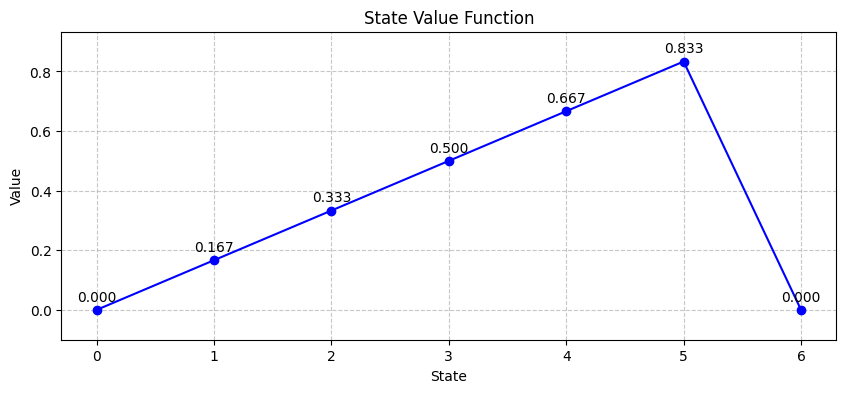

In [12]:
# Show the policy
agent.render_policy()

# Show the value function
agent.visualize()

Now that the policy and the target value function are ready, we can turn our attention to the methods for determining the state value function.

We implement the two methods in a way that returns a measure of the progress of learning for each episode. We use the root mean squared (RMS) error between the learned value function and the target value function. The methods return an array containing the RMS error of all learning episodes.

### Constant-&alpha; MC

With constant alpha MC, the update of the state value function is determined by comparing the return of a state with its current state value. In case there are deviations, the difference multiplied by the factor &alpha; is added to the state value.
Updates are always performed after the end of the episode for all passed states. In this implementation, updates are performed for every visit, whereby each visit is also a first visit due to the optimal policy.

In [13]:
def constant_alpha_MC(gamma, alpha, env, num_episodes, target_state_value_fn, policy):
    # Initialize state value function
    state_value_fn = np.zeros(mdp.num_states)
    state_value_fn[1:-1] += 0
    rms_errors = [] 
    for i_episode in range(1, num_episodes + 1):
        # Generate an episode using the policy
        episode = []
        obs, info = env.reset()
        done = False
        while not done:
            action = np.random.choice(len(policy[obs]), p=policy[obs])
            next_obs, reward, done, truncated, info = env.step(action)
            episode.append((obs, reward))
            obs = next_obs
        #print('NEW EPISODE')
        episode = np.array(episode)
        episode_duration = len(episode[:,:1])
        # Calculate returns for the whole episode from the back to save memory and resources
        G = np.zeros([episode_duration, ])
        for i in range(episode_duration - 1, -1, -1):
            if i + 1 > episode_duration - 1:
                G[i] = episode[i][1] # Last step of the episode
            else:
                G[i] = episode[i][1] + gamma * G[i + 1] # Every other step
        # Update the policy with constant-alpha MC
        for index in range(episode_duration):
            obs = int(episode[index][0])
            #print('state:', obs)
            #print('old value fn', state_value_fn[obs])
            state_value_fn[obs] = state_value_fn[obs] + alpha * (G[index] - state_value_fn[obs])
            #print('new value fn', state_value_fn[obs])
        # Calculate root mean squared error for the episode
        rms_error = np.sqrt(np.mean(np.square(state_value_fn - target_state_value_fn)))
        rms_errors.append(rms_error)
    return rms_errors

### TD(0)

In TD methods, the updates for the state value function are performed using the TD error. This error is the deviation between the state value of a state and the immediate reward, plus the discounted state value of the subsequent state. As with constant-&alpha; MC, in case of deviation, the error is added to the state value of a state with a factor alpha, however, not at the end of the episode but immediately. For TD(0), it is sufficient to observe a state, its reward, and subsequent state to determine the updates. The opposite of this behavior is TD(1), where the entire episode would be used for the error, so that updates could only be made at the end of the episode.

In [14]:
def td_0(gamma, alpha, env, num_episodes, target_state_value_fn, policy):
    # Initialize state value function
    state_value_fn = np.zeros(mdp.num_states)
    state_value_fn[1:-1] += 0
    rms_errors = []
    for i in range(num_episodes):
        # Update the value function based on the policy
        obs, info = env.reset() # Initial state
        done = False
        #print('NEW EPISODE')
        while not done:
            action = np.random.choice(len(policy[obs]), p=policy[obs]) # Get action from policy
            next_obs, reward, done, truncated, info = env.step(action)
            #print('state:', obs)
            #print('old value fn', state_value_fn[obs])
            state_value_fn[obs] = state_value_fn[obs] + alpha * (reward + ( gamma * state_value_fn[next_obs] ) - state_value_fn[obs])
            #print('old value fn', state_value_fn[obs])
            obs = next_obs
        # Calculate root mean squared error for the episode
        rms_error = np.sqrt(np.mean(np.square(state_value_fn - target_state_value_fn)))
        rms_errors.append(rms_error)
    return rms_errors

## Learning the State Value Functions

To obtain meaningful values, we perform the learning of the state value functions for both methods with multiple values of &alpha;. In addition, we use multiple runs for each value of &alpha; and average their values for the episodes using the `data_generator` method.

In [15]:
def data_generator(func, n_repeats, gamma, alpha, env, evaluation_episodes, target_state_value_fn, policy):
    data = []
    # Generate the data
    for i in range(n_repeats):
        data.append(func(gamma, alpha, env, evaluation_episodes, target_state_value_fn, policy))
    # Take the mean over the number of repeats
    mean_data = np.mean(data, axis=0)
    var_data = np.var(data, axis=0)
    return mean_data, var_data

First we test the convergence of both methods with small learning rates and a long training time. One can see that for carefully selected parameters both methods converge to a low RMS.

In [39]:
mc_conv = data_generator(constant_alpha_MC, 1, gamma, 0.0001, mdp, 100000, target_state_value_fn, policy)
td_conv = data_generator(td_0, 1, gamma, 0.0005, mdp, 100000, target_state_value_fn, policy)

print("Error constant-alpha MC: ", mc_conv[0][-1])
print("Error TD(0): ", td_conv[0][-1])

Error constant-alpha MC:  0.000744152909325086
Error TD(0):  0.005551292046295599


Now we use the `data_generator` to learn the state value functions for several values of &alpha; TD(0) and constant-&alpha; MC to get a plot of the mean RMS errors for each episode.

In [24]:
n_repeats = 100
evaluation_episodes = 150

# Generate MC runs
mc_10 = data_generator(constant_alpha_MC, n_repeats, gamma, 0.1, mdp, evaluation_episodes, target_state_value_fn, policy)
mc_20 = data_generator(constant_alpha_MC, n_repeats, gamma, 0.2, mdp, evaluation_episodes, target_state_value_fn, policy)
mc_30 = data_generator(constant_alpha_MC, n_repeats, gamma, 0.3, mdp, evaluation_episodes, target_state_value_fn, policy)

# Generate TD runs
td_10 = data_generator(td_0, n_repeats, gamma, 0.1, mdp, evaluation_episodes, target_state_value_fn, policy)
td_20 = data_generator(td_0, n_repeats, gamma, 0.2, mdp, evaluation_episodes, target_state_value_fn, policy)
td_30 = data_generator(td_0, n_repeats, gamma, 0.3, mdp, evaluation_episodes, target_state_value_fn, policy)

## Comparing the Results

Below we plot the RMS errors over the episodes. The dashed graphs represent constant-&alpha; MC, the solid ones represent TD(0). 
In contrast to the frozen lake example the MC method converges at a very high RMS. This is due to the high stochasticity in the env that leads to high-variance MC samples and therefore high variance updates.

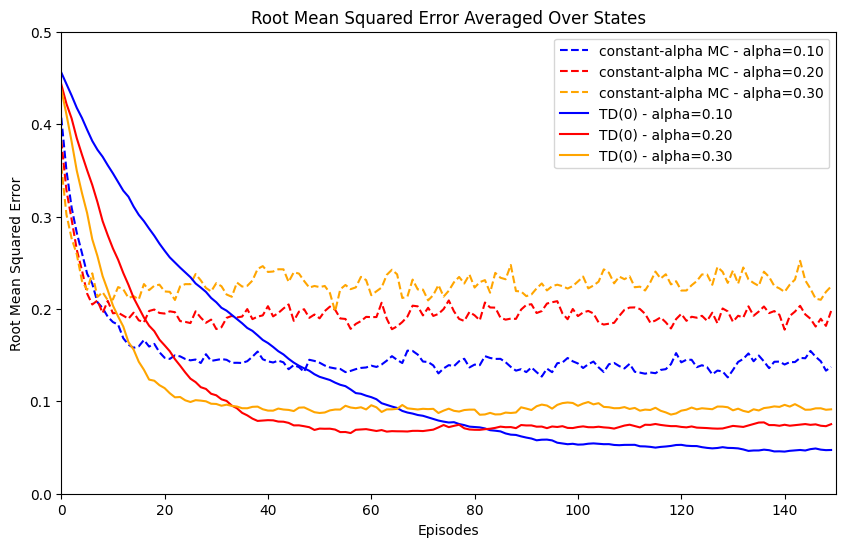

In [25]:
# Display the data
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes.
ax.plot(range(evaluation_episodes), mc_10[0], label="constant-alpha MC - alpha=0.10", linestyle='dashed', color='blue')
ax.plot(range(evaluation_episodes), mc_20[0], label="constant-alpha MC - alpha=0.20", linestyle='dashed', color='red')
ax.plot(range(evaluation_episodes), mc_30[0], label="constant-alpha MC - alpha=0.30", linestyle='dashed', color='orange')
ax.plot(range(evaluation_episodes), td_10[0], label="TD(0) - alpha=0.10", color='blue')
ax.plot(range(evaluation_episodes), td_20[0], label="TD(0) - alpha=0.20", color='red')
ax.plot(range(evaluation_episodes), td_30[0], label="TD(0) - alpha=0.30", color='orange')
ax.grid(False)
ax.set_xlabel('Episodes')
ax.set_ylabel('Root Mean Squared Error')
ax.set_title('Root Mean Squared Error Averaged Over States')
ax.set_ylim(0, 0.5)
ax.set_xlim(0, evaluation_episodes)
ax.legend()
plt.show()

Now we tried to match the learning rate such that the convergence seed of both methods match at the beginning. One can see that the MC methods still converge at a higher RMS and have a less smoother curve even though averaged over 50 runs.

This can also be seen in the next two plots that show the variance over these 50 runs. MC has higher variance.

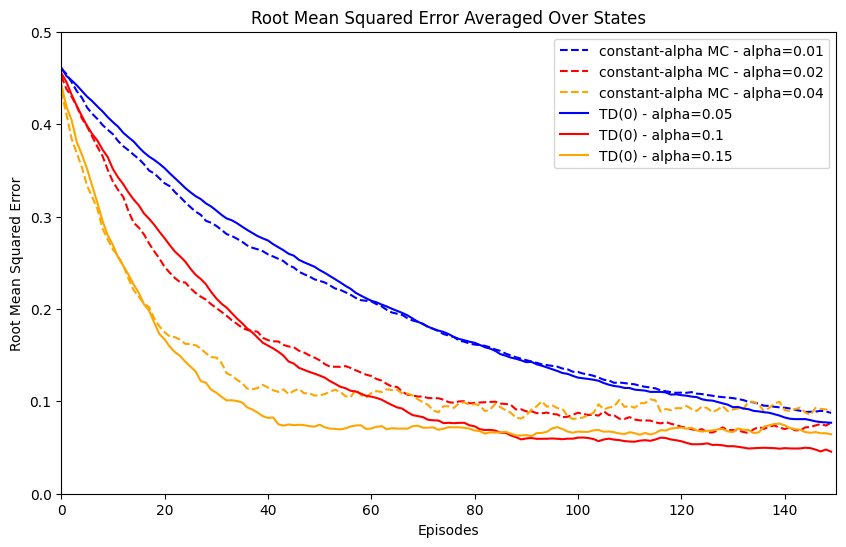

In [32]:
n_repeats = 50
evaluation_episodes = 150

# Generate MC runs
mc_10 = data_generator(constant_alpha_MC, n_repeats, gamma, 0.01, mdp, evaluation_episodes, target_state_value_fn,
                       policy)
mc_20 = data_generator(constant_alpha_MC, n_repeats, gamma, 0.02, mdp, evaluation_episodes, target_state_value_fn,
                       policy)
mc_40 = data_generator(constant_alpha_MC, n_repeats, gamma, 0.04, mdp, evaluation_episodes, target_state_value_fn, policy)

# Generate TD runs
td_10 = data_generator(td_0, n_repeats, gamma, 0.05, mdp, evaluation_episodes, target_state_value_fn, policy)
td_20 = data_generator(td_0, n_repeats, gamma, 0.1, mdp, evaluation_episodes, target_state_value_fn, policy)
td_30 = data_generator(td_0, n_repeats, gamma, 0.19, mdp, evaluation_episodes, target_state_value_fn, policy)
## Comparing the Results

# Display the data
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes.
ax.plot(range(evaluation_episodes), mc_10[0], label="constant-alpha MC - alpha=0.01", linestyle='dashed', color='blue')
ax.plot(range(evaluation_episodes), mc_20[0], label="constant-alpha MC - alpha=0.02", linestyle='dashed', color='red')
ax.plot(range(evaluation_episodes), mc_40[0], label="constant-alpha MC - alpha=0.04", linestyle='dashed', color='orange')
ax.plot(range(evaluation_episodes), td_10[0], label="TD(0) - alpha=0.05", color='blue')
ax.plot(range(evaluation_episodes), td_20[0], label="TD(0) - alpha=0.1", color='red')
ax.plot(range(evaluation_episodes), td_30[0], label="TD(0) - alpha=0.15", color='orange')
ax.grid(False)
ax.set_xlabel('Episodes')
ax.set_ylabel('Root Mean Squared Error')
ax.set_title('Root Mean Squared Error Averaged Over States')
ax.set_ylim(0, 0.5)
ax.set_xlim(0, evaluation_episodes)
ax.legend()
plt.show()

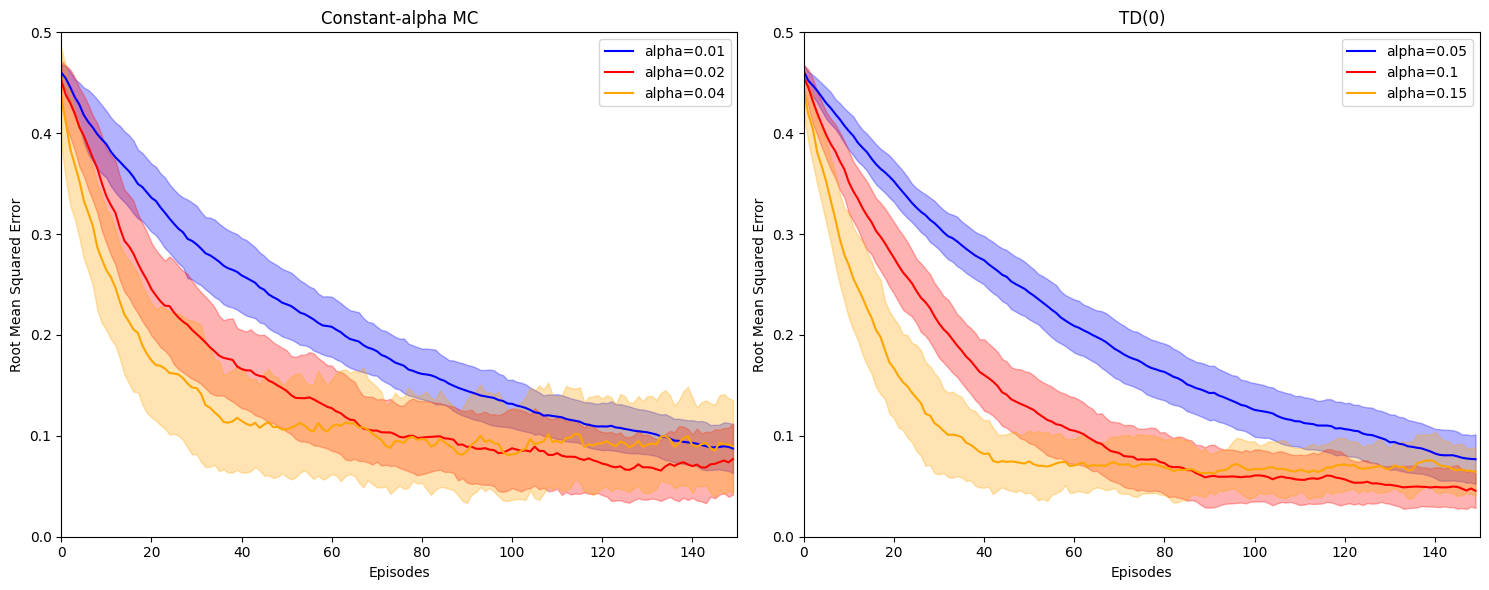

In [33]:
# Display the data in two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Create a figure with two axes side by side

# Plot for constant-alpha MC in the first subplot
ax1.plot(range(evaluation_episodes), mc_10[0], label="alpha=0.01", color='blue')
ax1.fill_between(range(evaluation_episodes),
                 mc_10[0] - np.sqrt(mc_10[1]),
                 mc_10[0] + np.sqrt(mc_10[1]),
                 alpha=0.3, color='blue')

ax1.plot(range(evaluation_episodes), mc_20[0], label="alpha=0.02", color='red')
ax1.fill_between(range(evaluation_episodes),
                 mc_20[0] - np.sqrt(mc_20[1]),
                 mc_20[0] + np.sqrt(mc_20[1]),
                 alpha=0.3, color='red')

ax1.plot(range(evaluation_episodes), mc_40[0], label="alpha=0.04", color='orange')
ax1.fill_between(range(evaluation_episodes),
                 mc_40[0] - np.sqrt(mc_40[1]),
                 mc_40[0] + np.sqrt(mc_40[1]),
                 alpha=0.3, color='orange')

ax1.grid(False)
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Root Mean Squared Error')
ax1.set_title('Constant-alpha MC')
ax1.set_ylim(0, 0.5)
ax1.set_xlim(0, evaluation_episodes)
ax1.legend()

# Plot for TD(0) in the second subplot
ax2.plot(range(evaluation_episodes), td_10[0], label="alpha=0.05", color='blue')
ax2.fill_between(range(evaluation_episodes),
                 td_10[0] - np.sqrt(td_10[1]),
                 td_10[0] + np.sqrt(td_10[1]),
                 alpha=0.3, color='blue')

ax2.plot(range(evaluation_episodes), td_20[0], label="alpha=0.1", color='red')
ax2.fill_between(range(evaluation_episodes),
                 td_20[0] - np.sqrt(td_20[1]),
                 td_20[0] + np.sqrt(td_20[1]),
                 alpha=0.3, color='red')

ax2.plot(range(evaluation_episodes), td_30[0], label="alpha=0.15", color='orange')
ax2.fill_between(range(evaluation_episodes),
                 td_30[0] - np.sqrt(td_30[1]),
                 td_30[0] + np.sqrt(td_30[1]),
                 alpha=0.3, color='orange')

ax2.grid(False)
ax2.set_xlabel('Episodes')
ax2.set_ylabel('Root Mean Squared Error')
ax2.set_title('TD(0)')
ax2.set_ylim(0, 0.5)
ax2.set_xlim(0, evaluation_episodes)
ax2.legend()

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

Here one can see the direct comparison of the variance between 50 runs of the MC and TD method.

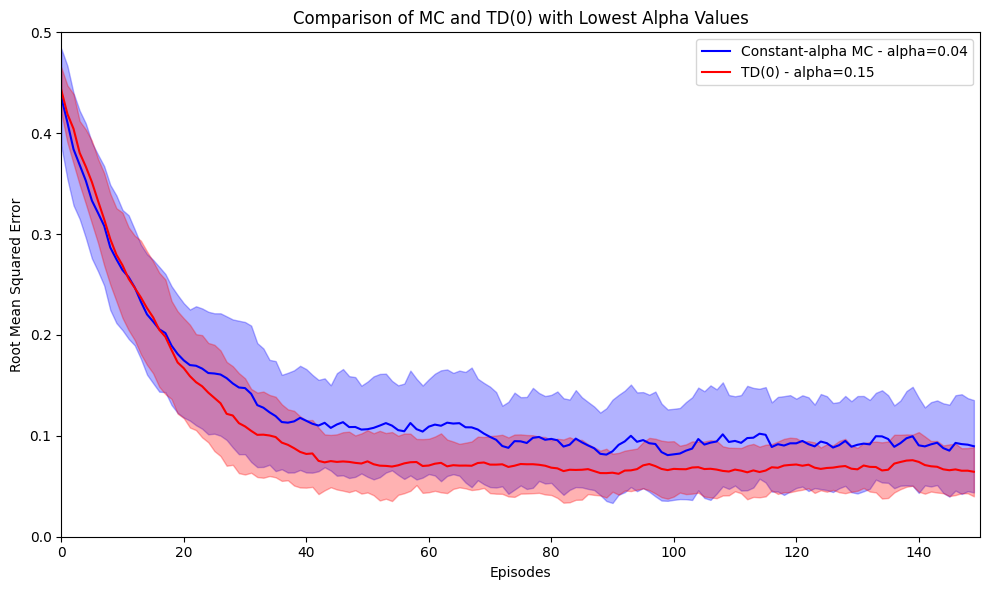

In [34]:
# Display the data in a single plot with lowest alpha values from each method
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure with a single axes

# Plot for constant-alpha MC with lowest alpha (0.01)
ax.plot(range(evaluation_episodes), mc_40[0], label="Constant-alpha MC - alpha=0.04", color='blue')
ax.fill_between(range(evaluation_episodes),
                mc_40[0] - np.sqrt(mc_40[1]),
                mc_40[0] + np.sqrt(mc_40[1]),
                alpha=0.3, color='blue')

# Plot for TD(0) with lowest alpha (0.05)
ax.plot(range(evaluation_episodes), td_30[0], label="TD(0) - alpha=0.15", color='red')
ax.fill_between(range(evaluation_episodes),
                td_30[0] - np.sqrt(td_30[1]),
                td_30[0] + np.sqrt(td_30[1]),
                alpha=0.3, color='red')

ax.grid(False)
ax.set_xlabel('Episodes')
ax.set_ylabel('Root Mean Squared Error')
ax.set_title('Comparison of MC and TD(0) with Lowest Alpha Values')
ax.set_ylim(0, 0.5)
ax.set_xlim(0, evaluation_episodes)
ax.legend()

plt.tight_layout()
plt.show()